In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pip install librosa

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# Remove np_utils from the import statement as it's no longer needed
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

##  <center> 3. TESS dataset <center>

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# def pitch(data, sampling_rate, pitch_factor=0.7):
#     return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


def pitch(data, sampling_rate, n_steps=0.7):  # Changed pitch_factor to n_steps for clarity
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=n_steps)


def extract_features(data,sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data,sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data= stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch,sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

# X= []

# path='/content/drive/MyDrive/MCA Dataset/dev_data/302_AUDIO.wav'
# feature = get_features(path)
# for ele in feature:
#     X.append(ele)

# Features = pd.DataFrame(X)

In [ ]:
devData = np.array(pd.read_csv('/content/drive/My Drive/MCA Dataset/dev_split_Depression_AVEC2017.csv',delimiter=',',encoding='utf-8'))[:, 0:2]
testData = np.array(pd.read_csv('/content/drive/My Drive/MCA Dataset/full_test_split.csv',delimiter=',',encoding='utf-8'))[:, 0:2]
trainData = np.array(pd.read_csv('/content/drive/My Drive/MCA Dataset/train_split_Depression_AVEC2017.csv',delimiter=',',encoding='utf-8'))[:, 0:2]


In [ ]:
def checkDataPointExistence(patientID, split):
  for i in split:
    if(patientID == i[0]):
      return True
  return False

In [ ]:
X, Y = [], []
for path, emotion in zip(Crema_df.Path, Crema_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
# Load the dataset with participant IDs and their corresponding labels
labels_df = pd.read_csv('/content/drive/My Drive/MCA Dataset/dev_split_Depression_AVEC2017.csv', delimiter=',', encoding='utf-8')

# Directory containing the audio files
audio_dir = '/content/drive/MyDrive/MCA Dataset/dev_data'

# Prepare a mapping from Participant_ID to PHQ8_Binary
id_to_emotion = pd.Series(labels_df.PHQ8_Binary.values, index=labels_df.Participant_ID).to_dict()

# Lists to hold the extracted features and corresponding labels
X, Y = [], []

# Process each audio file in the directory
for filename in os.listdir(audio_dir):
    if filename.endswith('.wav') and filename.count('_') == 1:
        # Extract Participant_ID from the filename
        # The filename format is "302_AUDIO.wav", so we split by '_' and take the first part
        participant_id = int(filename.split('_')[0])

        # Skip processing if the participant is not in the labels dataframe
        if participant_id not in id_to_emotion:
            continue

        # Get the corresponding label for this participant
        emotion = id_to_emotion[participant_id]

        # Full path to the audio file
        file_path = os.path.join(audio_dir, filename)
        # print(file_path)
        # print(emotion)
        # print(filename)
        # print(participant_id)
        # break


        # Extract features
        features = get_features(file_path)

        # Append features and labels
        for feature in features:
            X.append(feature)
            Y.append(emotion)  # Appending the emotion label for each feature extracted

# At this point, X is a list of features and Y is a list of corresponding labels.


In [ ]:
# Load the dataset with participant IDs and their corresponding labels
labels_df = pd.read_csv('/content/drive/My Drive/MCA Dataset/train_split_Depression_AVEC2017.csv', delimiter=',', encoding='utf-8')

# Directory containing the audio files
audio_dir = '/content/drive/MyDrive/MCA Dataset/train_data'

# Prepare a mapping from Participant_ID to PHQ8_Binary
id_to_emotion = pd.Series(labels_df.PHQ8_Binary.values, index=labels_df.Participant_ID).to_dict()

# Lists to hold the extracted features and corresponding labels
X, Y = [], []
c=0
# Process each audio file in the directory
for filename in os.listdir(audio_dir):

    if filename.endswith('.wav') and filename.count('_') == 1:

        # Extract Participant_ID from the filename
        # The filename format is "302_AUDIO.wav", so we split by '_' and take the first part
        participant_id = int(filename.split('_')[0])
        if participant_id>= 440 :
          c=c+1


          # print(file_path)
          # print(emotion)
          # print(filename)
          # print(participant_id)
          # break


          # Skip processing if the participant is not in the labels dataframe
          if participant_id not in id_to_emotion:
              continue

          # Get the corresponding label for this participant
          emotion = id_to_emotion[participant_id]

          # Full path to the audio file
          file_path = os.path.join(audio_dir, filename)



          # Extract features
          features = get_features(file_path)

          # Append features and labels
          for feature in features:
              X.append(feature)
              Y.append(emotion)  # Appending the emotion label for each feature extracted
print(c)
# At this point, X is a list of features and Y is a list of corresponding labels.


27


In [ ]:
print(len(X[0]))

162


In [ ]:
len(X), len(Y)

(81, 81)

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features3.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.044660,0.796911,0.805765,0.797193,0.793657,0.807335,0.813584,0.798822,0.840821,0.889179,...,5.245785e-11,4.875256e-11,4.612075e-11,4.415840e-11,4.269685e-11,4.164807e-11,4.088695e-11,4.039629e-11,4.009137e-11,1
1,0.047142,0.811304,0.818460,0.811047,0.809669,0.821628,0.815442,0.788887,0.830039,0.878441,...,8.605178e-09,8.388205e-09,8.075597e-09,8.550305e-09,8.726810e-09,8.550608e-09,8.595045e-09,7.986999e-09,8.400312e-09,1
2,0.047425,0.787183,0.782049,0.740005,0.750662,0.764455,0.794102,0.791748,0.813907,0.838001,...,3.851564e-11,3.410677e-11,3.083212e-11,2.860433e-11,2.696793e-11,2.573537e-11,2.497816e-11,1.994450e-11,7.712622e-12,1
3,0.034333,0.834362,0.832510,0.818167,0.871688,0.874627,0.875385,0.856701,0.813531,0.836067,...,5.273030e-11,4.878389e-11,4.598941e-11,4.391190e-11,4.236640e-11,4.125524e-11,4.044916e-11,3.992722e-11,3.960414e-11,0
4,0.038231,0.857938,0.854511,0.842768,0.902083,0.883904,0.877007,0.819352,0.789198,0.837028,...,1.721167e-08,1.736957e-08,1.683692e-08,1.752589e-08,1.754852e-08,1.619338e-08,1.781451e-08,1.821153e-08,1.664945e-08,0


In [ ]:
import pandas as pd

# Load your data
data_frame1 = pd.read_csv('concatenated_features2.csv')
data_frame2 = pd.read_csv('features3.csv')

# Concatenate your data
concatenated_data = pd.concat([data_frame1, data_frame2])

# If you want to reset the index (optional)
concatenated_data.reset_index(drop=True, inplace=True)

# Save the new concatenated data
concatenated_data.to_csv('concatenated_features3.csv', index=False)


In [ ]:
concatenated_data.shape

(426, 163)

In [ ]:
X = concatenated_data.iloc[: ,:-1].values
Y = concatenated_data['labels'].values

In [ ]:
X.shape


(426, 162)

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((319, 162), (319,), (107, 162), (107,))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((319, 162), (319,), (107, 162), (107,))

In [ ]:
import joblib

# ... (after fitting the scaler on the training data)
joblib.dump(scaler, 'scaler_filename.pkl')  # Save the scaler to a file

['scaler_filename.pkl']

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((319, 162, 1), (319,), (107, 162, 1), (107,))

In [ ]:

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense

# Assuming your x_train, y_train, x_test, y_test have been prepared correctly
# and your data has been shaped appropriately.

model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

# Change this layer for binary classification
model.add(Dense(units=1, activation='sigmoid'))  # Changed from 'softmax' to 'sigmoid' and units to 1

# Compile the model with binary crossentropy for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [ ]:
epochs=50
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
5/5 [==============================] - 2s 413ms/step - loss: 0.5291 - accuracy: 0.7147 - val_loss: 0.6037 - val_accuracy: 0.6729 - lr: 1.0000e-07
Epoch 2/50
5/5 [==============================] - 2s 411ms/step - loss: 0.5299 - accuracy: 0.7147 - val_loss: 0.6037 - val_accuracy: 0.6729 - lr: 1.0000e-07
Epoch 3/50
5/5 [==============================] - 3s 702ms/step - loss: 0.5282 - accuracy: 0.7179 - val_loss: 0.6037 - val_accuracy: 0.6729 - lr: 1.0000e-07
Epoch 4/50
5/5 [==============================] - 2s 394ms/step - loss: 0.5465 - accuracy: 0.7179 - val_loss: 0.6037 - val_accuracy: 0.6729 - lr: 1.0000e-07
Epoch 5/50
5/5 [==============================] - 2s 398ms/step - loss: 0.5346 - accuracy: 0.7179 - val_loss: 0.6037 - val_accuracy: 0.6729 - lr: 1.0000e-07
Epoch 6/50
5/5 [==============================] - 2s 396ms/step - loss: 0.5343 - accuracy: 0.7147 - val_loss: 0.6037 - val_accuracy: 0.6729 - lr: 1.0000e-07
Epoch 7/50
5/5 [==============================] - 2s 401ms

4/4 [==============================] - 0s 36ms/step - loss: 0.6036 - accuracy: 0.6729
Accuracy of our model on test data :  67.2897219657898 %


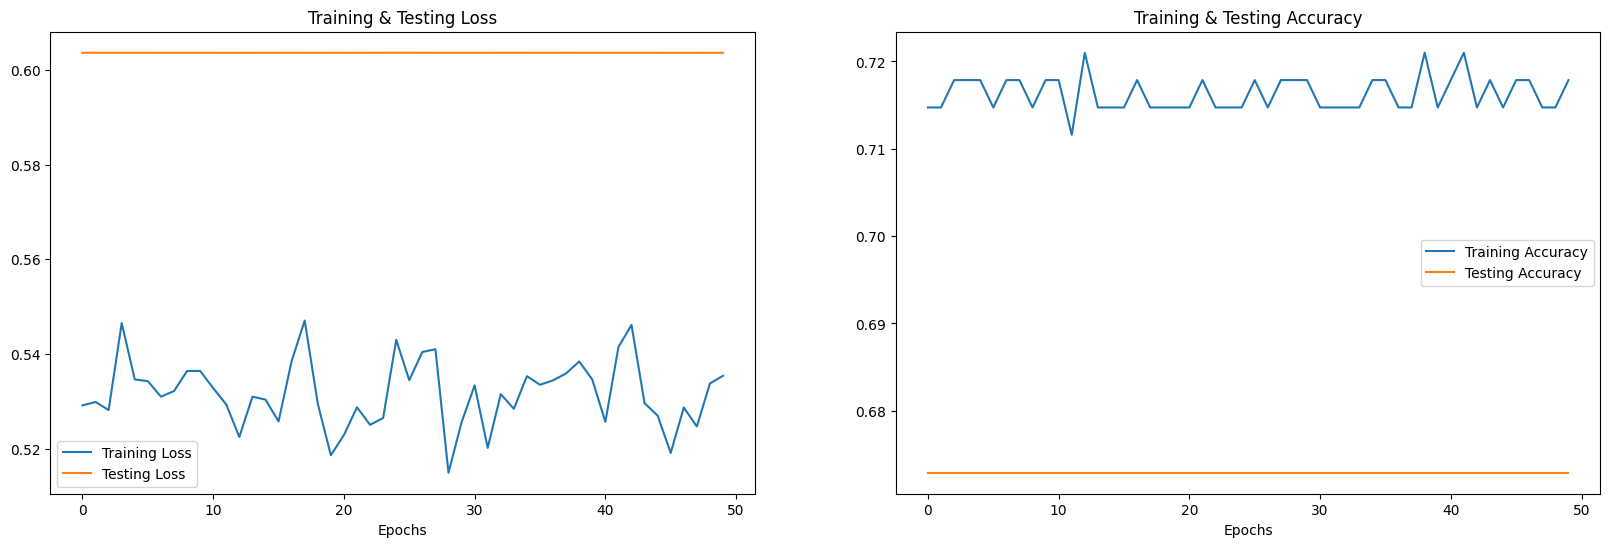

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(x_test)

4/4 [==============================] - 0s 40ms/step


In [ ]:
pred_test[0]

array([0.23920977], dtype=float32)

In [ ]:
def Thresholding(Y_pred, threshold):
  Y_pred2 = []
  print("Y_pred: ", Y_pred.shape)
  for i in range(len(Y_pred)):
    if(Y_pred[i] < threshold):
      Y_pred2.append(0)
    else:
      Y_pred2.append(1)

  return np.array(Y_pred2)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_labels, figsize=(12, 10)):
    """
    Plots a confusion matrix using seaborn heatmap.

    Parameters:
    y_true (array): Array of true label values.
    y_pred (array): Array of predicted label values.
    class_labels (list): List of class labels (str) for the confusion matrix.
    figsize (tuple): Tuple representing the figure size (width, height).

    Returns:
    None
    """
    # Validate that class_labels is a list of strings
    if not all(isinstance(label, str) for label in class_labels):
        raise ValueError("class_labels must be a list of strings representing class names.")

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a DataFrame from the confusion matrix for visualization
    cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

    # Create a heatmap from the DataFrame
    plt.figure(figsize=figsize)
    sns.heatmap(cm_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='d')  # 'd' specifies integer formatting
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

# Usage of the function with your data:



In [ ]:
from sklearn.metrics import classification_report
Threshold=0.29292929292929293
pred = model.predict(x_train)
y_train_X=Thresholding(y_train,Threshold)
pred_th =Thresholding(pred,Threshold)
y_train_X , pred_th


10/10 [==============================] - 0s 47ms/step
Y_pred:  (319,)
Y_pred:  (319, 1)


(array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 

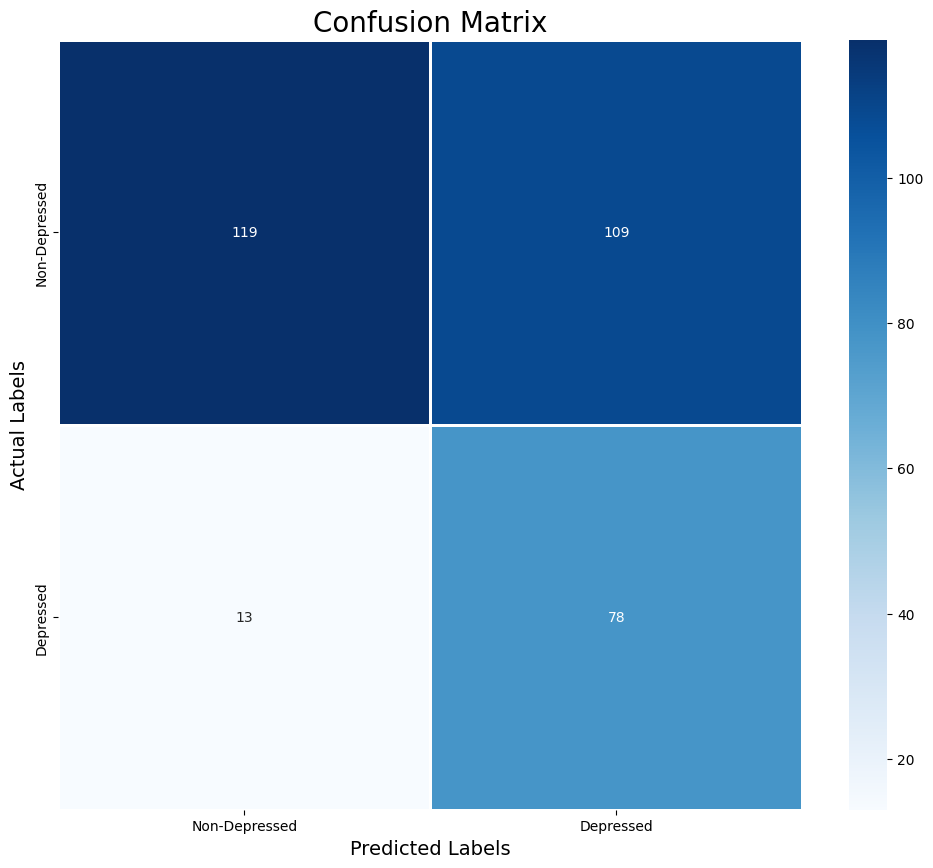

In [ ]:
# from sklearn.metrics import classification_report
Threshold=0.29292929292929293
# pred = model.predict(x_train)
# y_train_X=Thresholding(y_test,Threshold)
# pred_th =Thresholding(pred,Threshold)
class_labels = ['Non-Depressed', 'Depressed']  # Define the labels for your binary classification
plot_confusion_matrix(y_train_X, pred_th, class_labels)
# print(classification_report(y_train,Thresholding(pred,0.1)))
# print(classification_report(y_train,Thresholding(pred,0.2)))
# print(classification_report(y_train,Thresholding(pred,0.28)))

# print(classification_report(y_train,Thresholding(pred,0.3)))
# print(classification_report(y_train,Thresholding(pred,Threshold)))
# print(classification_report(y_train,Thresholding(pred,0.37)))
# print(classification_report(y_train,Thresholding(pred,0.38)))
# print(classification_report(y_train,Thresholding(pred,0.39)))

# print(classification_report(y_train,Thresholding(pred,0.4)))
# print(classification_report(y_train,Thresholding(pred,0.5)))
# print(classification_report(y_train,Thresholding(pred,0.6)))
# print(classification_report(y_train,Thresholding(pred,0.7)))
# print(classification_report(y_train,Thresholding(pred,0.8)))
# print(classification_report(y_train,Thresholding(pred,0.9)))
# print(classification_report(y_train,Thresholding(pred,0.95)))
# print(classification_report(y_train,Thresholding(pred,0.98)))




10/10 [==============================] - 0s 45ms/step


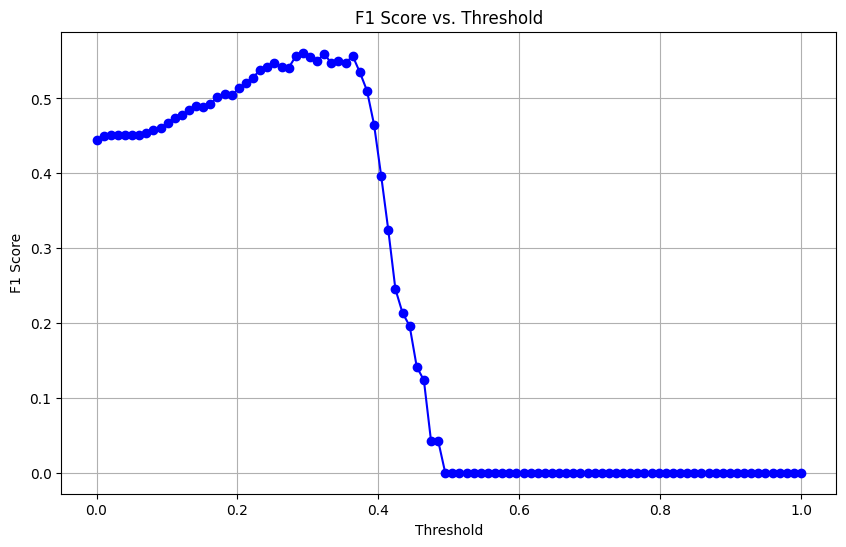

Optimal Threshold: 0.29292929292929293
Maximum F1 Score: 0.5611510791366907


In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
pred = model.predict(x_train)

def find_optimal_threshold(y_true, y_pred_prob, thresholds):
    """
    Iterate over a range of threshold values to find the optimal threshold based on F1 score.

    Parameters:
    y_true (array): Array of true label values.
    y_pred_prob (array): Array of predicted probabilities.
    thresholds (list/np.ndarray): An array of threshold values to test.

    Returns:
    A tuple containing the optimal threshold and the plot of F1 scores.
    """
    # Initialize variables to store the scores and the best threshold
    f1_scores = []
    best_threshold = None
    max_f1 = 0

    # Iterate over all thresholds and calculate F1 score for each
    for threshold in thresholds:
        # Apply threshold to positive probabilities to create binary predictions
        y_pred = (y_pred_prob >= threshold).astype(int)

        # Calculate and store the F1 score
        score = f1_score(y_true, y_pred)
        f1_scores.append(score)

        # If the current score is better than the previous best, update the best threshold
        if score > max_f1:
            max_f1 = score
            best_threshold = threshold

    # Plot F1 scores vs. thresholds
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, marker='o', linestyle='-', color='b')
    plt.title('F1 Score vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.show()

    return best_threshold, max_f1

# Usage of the function with your data:
# pred is the array of predicted probabilities from your model
thresholds = np.linspace(0, 1, 100)  # Creates 100 points from 0 to 1
optimal_threshold, max_f1 = find_optimal_threshold(y_train, pred, thresholds)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Maximum F1 Score: {max_f1}")


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
# save model structure in jason file
model_json = model.to_json()
with open("depression_model_using_wav_audio.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
model.save_weights('depression_model_using_wav_audio.h5')

In [ ]:
from tensorflow.keras.models import load_model

model_path = 'my_model.h5'
model = load_model(model_path)


In [ ]:
pred_test = model.predict(x_test)



1/1 [==============================] - 0s 135ms/step


In [ ]:
pred_test[0]

array([0.23920977], dtype=float32)

In [ ]:
emotions = ['disgust','happy','sad', 'neutral' ,'fear','angry']


In [ ]:
import numpy as np

# 'pred_test' is the array you got from 'model.predict(x_test)'
for idx, prediction in enumerate(pred_test):
    print(f"Sample {idx+1} predictions:")
    for emotion, probability in zip(emotions, prediction):
        print(f"{emotion}: {probability:.5f}")  # '.5f' for 5 decimal precision, adjust as needed
    print("")  # for a new line between samples


Sample 1 predictions:
disgust: 0.00203
happy: 0.03038
sad: 0.03134
neutral: 0.50983
fear: 0.41979
angry: 0.00662

Sample 2 predictions:
disgust: 0.00120
happy: 0.14219
sad: 0.04796
neutral: 0.06023
fear: 0.64181
angry: 0.10661

Sample 3 predictions:
disgust: 0.00000
happy: 0.07447
sad: 0.00068
neutral: 0.00059
fear: 0.89091
angry: 0.03335



In [ ]:
for idx, prediction in enumerate(pred_test):
    print(f"Sample {idx+1} predictions:")
    highest_probability_index = np.argmax(prediction)
    dominant_emotion = emotions[highest_probability_index]
    print(f"Dominant emotion: {dominant_emotion} (Probability: {prediction[highest_probability_index]:.5f})")
    print("")  # for a new line between samples


Sample 1 predictions:
Dominant emotion: neutral (Probability: 0.50983)

Sample 2 predictions:
Dominant emotion: fear (Probability: 0.64181)

Sample 3 predictions:
Dominant emotion: fear (Probability: 0.89091)



In [ ]:
import numpy as np

# Assuming 'pred_test' is your predictions array
# and 'emotions' is your list of emotion labels.

# Calculate the mean probabilities across all samples.
mean_probabilities = np.mean(pred_test, axis=0)

# Create a dictionary of emotions and their average probabilities.
average_emotion_probabilities = dict(zip(emotions, mean_probabilities))

# Print the average probabilities.
for emotion, avg_prob in average_emotion_probabilities.items():
    print(f"Average probability for {emotion}: {avg_prob:.5f}")  # '.5f' for 5 decimal precision, adjust as needed


Average probability for disgust: 0.00108
Average probability for happy: 0.08235
Average probability for sad: 0.02666
Average probability for neutral: 0.19022
Average probability for fear: 0.65084
Average probability for angry: 0.04886


In [ ]:
import pandas as pd
import numpy as np
import joblib
import librosa
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import keras
model_path_json = 'depression_model_using_wav_audio.json'
model_path = 'depression_model_using_wav_audio.h5'
path_of_wav_audio_file='/content/dilshad.wav'
path_of_scaler_filename='scaler_filename_dep.pkl'

def emotion_model_using_wav_audio(path):
  def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

  def stretch(data, rate=0.8):
      return librosa.effects.time_stretch(y=data, rate=rate)


  def shift(data):
      shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
      return np.roll(data, shift_range)

  def pitch(data, sampling_rate, n_steps=0.7):  # Changed pitch_factor to n_steps for clarity
      return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=n_steps)


  def extract_features(data,sample_rate):
      # ZCR
      result = np.array([])
      zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
      result=np.hstack((result, zcr)) # stacking horizontally

      # Chroma_stft
      stft = np.abs(librosa.stft(data))
      chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
      result = np.hstack((result, chroma_stft)) # stacking horizontally

      # MFCC
      mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
      result = np.hstack((result, mfcc)) # stacking horizontally

      # Root Mean Square Value
      rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
      result = np.hstack((result, rms)) # stacking horizontally

      # MelSpectogram
      mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
      result = np.hstack((result, mel)) # stacking horizontally

      return result

  def get_features(path):
      # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
      data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

      # without augmentation
      res1 = extract_features(data,sample_rate)
      result = np.array(res1)

      # data with noise
      noise_data = noise(data)
      res2 = extract_features(noise_data,sample_rate)
      result = np.vstack((result, res2)) # stacking vertically

      # data with stretching and pitching
      new_data= stretch(data)
      data_stretch_pitch = pitch(new_data, sample_rate)
      res3 = extract_features(data_stretch_pitch,sample_rate)
      result = np.vstack((result, res3)) # stacking vertically

      return result

  X= []
  feature = get_features(path)
  for ele in feature:
      X.append(ele)
  print(X)
  Features = pd.DataFrame(X)
  scaler = joblib.load(path_of_scaler_filename)
  x_test = scaler.transform(Features)
  x_test = np.expand_dims(x_test, axis=2)
  from keras.models import model_from_json
  with open(model_path_json, "r") as json_file:
      model_json = json_file.read()
  model = model_from_json(model_json)
  model.load_weights(model_path)

  pred_test = model.predict(x_test)
  Threshold=0.29
  print(pred_test)
  # if(pred_test>= Threshold):
  #     return 1
  # else:
  #     return 0





emotion_model_using_wav_audio(path_of_wav_audio_file)






[array([ 1.31939923e-01,  4.81229514e-01,  4.93591428e-01,  5.60769916e-01,
        6.19068563e-01,  6.23519182e-01,  6.12370670e-01,  6.05483353e-01,
        6.03899837e-01,  7.44159758e-01,  6.48446560e-01,  6.32136941e-01,
        5.86543977e-01, -4.52991058e+02,  1.04136787e+02, -2.95264359e+01,
        2.79714928e+01,  1.20627618e+00,  5.75142860e+00, -1.38688147e+00,
       -1.30714598e+01, -2.42378578e+01,  2.93504524e+00,  7.55405426e-01,
       -1.25246210e+01, -6.64178371e+00, -1.07452555e+01,  9.33059990e-01,
       -6.80066729e+00, -6.65920973e+00, -7.68704510e+00, -6.51006174e+00,
       -4.41845512e+00,  1.56220477e-02,  7.37039489e-04,  1.59258590e-04,
        3.19598392e-02,  7.41235077e-01,  7.06940532e-01,  6.76031485e-02,
        3.19979936e-02,  5.40725648e-01,  3.23551512e+00,  2.63583517e+00,
        1.33443609e-01,  1.83582038e-01,  3.51782441e-01,  3.24006915e-01,
        1.93430722e-01,  1.45070717e-01,  1.73425600e-01,  3.32195312e-01,
        1.20765173e+00, 

In [ ]:

path='/content/drive/MyDrive/MCA Dataset/dev_data/302_AUDIO.wav'
emotion_model_using_wav_audio(path)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1/1 [==============================] - 0s 208ms/step


{'disgust': 0.0008836287,
 'happy': 0.0679561,
 'sad': 0.03787496,
 'neutral': 0.1905356,
 'fear': 0.63908046,
 'angry': 0.06366926}

In [ ]:
# import pandas as pd
# import numpy as np
# import joblib
# import librosa
# from tensorflow.keras.models import load_model
# from sklearn.preprocessing import StandardScaler
# import keras
# model_path_json = 'depression_model_using_wav_audio.json'
# model_path = 'depression_model_using_wav_audio.h5'
# path_of_wav_audio_file='/content/dilshad.wav'
# path_of_scaler_filename='scaler_filename_dep.pkl'

# def emotion_model_using_wav_audio(path):
#   def noise(data):
#     noise_amp = 0.035*np.random.uniform()*np.amax(data)
#     data = data + noise_amp*np.random.normal(size=data.shape[0])
#     return data

#   def stretch(data, rate=0.8):
#       return librosa.effects.time_stretch(y=data, rate=rate)


#   def shift(data):
#       shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
#       return np.roll(data, shift_range)

#   def pitch(data, sampling_rate, n_steps=0.7):  # Changed pitch_factor to n_steps for clarity
#       return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=n_steps)


#   def extract_features(data,sample_rate):
#       # ZCR
#       result = np.array([])
#       zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
#       result=np.hstack((result, zcr)) # stacking horizontally

#       # Chroma_stft
#       stft = np.abs(librosa.stft(data))
#       chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
#       result = np.hstack((result, chroma_stft)) # stacking horizontally

#       # MFCC
#       mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
#       result = np.hstack((result, mfcc)) # stacking horizontally

#       # Root Mean Square Value
#       rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
#       result = np.hstack((result, rms)) # stacking horizontally

#       # MelSpectogram
#       mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
#       result = np.hstack((result, mel)) # stacking horizontally

#       return result

#   def get_features(path):
#       # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
#       data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

#       # without augmentation
#       res1 = extract_features(data,sample_rate)
#       result = np.array(res1)

#       # data with noise
#       noise_data = noise(data)
#       res2 = extract_features(noise_data,sample_rate)
#       result = np.vstack((result, res2)) # stacking vertically

#       # data with stretching and pitching
#       new_data= stretch(data)
#       data_stretch_pitch = pitch(new_data, sample_rate)
#       res3 = extract_features(data_stretch_pitch,sample_rate)
#       result = np.vstack((result, res3)) # stacking vertically

#       return result

#   X= []
#   features = get_features(path)
#   for feature in features:
#     X.append(feature)
#   Features = pd.DataFrame(X)
#   X = Features.iloc[: ,:-1].values
#   scaler = joblib.load(path_of_scaler_filename)
#   x_test = scaler.transform(Features)
#   x_test = np.expand_dims(x_test, axis=2)
#   from keras.models import model_from_json
#   with open(model_path_json, "r") as json_file:
#       model_json = json_file.read()
#   model = model_from_json(model_json)
#   model.load_weights(model_path)

#   pred_test = model.predict(x_test)
#   Threshold=0.29
#   print(pred_test)
#   # if(pred_test>= Threshold):
#   #     return 1
#   # else:
#   #     return 0





# emotion_model_using_wav_audio(path_of_wav_audio_file)






1/1 [==============================] - 0s 138ms/step
[[3.6416089e-04]
 [2.8599208e-05]
 [6.2248442e-02]]
